In [22]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.0.0-beta0
sys.version_info(major=3, minor=7, micro=0, releaselevel='final', serial=0)
matplotlib 3.0.3
numpy 1.16.0
pandas 0.24.2
sklearn 0.21.3
tensorflow 2.0.0-beta0
tensorflow.python.keras.api._v2.keras 2.2.4-tf


In [23]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [24]:
from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(
    housing.data, housing.target, random_state = 7)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state = 11)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)


(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

In [26]:
# RandomizedSearchCV
# 1. 转化为sklearn的model
# 2. 定义参数集合
# 3. 搜索参数

def build_model(hidden_layers = 1,
                layer_size = 30,
                learning_rate = 3e-3):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(layer_size, activation='relu',
                                 input_shape=x_train.shape[1:]))
    for _ in range(hidden_layers - 1):
        model.add(keras.layers.Dense(layer_size,
                                     activation = 'relu'))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss = 'mse', optimizer = optimizer)
    return model

sklearn_model = keras.wrappers.scikit_learn.KerasRegressor(
    build_fn = build_model)
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2)]
history = sklearn_model.fit(x_train_scaled, y_train,
                            epochs = 10,
                            validation_data = (x_valid_scaled, y_valid),
                            callbacks = callbacks)

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 0s 27us/sample - loss: 1.2120 - val_loss: 0.7007
Epoch 2/10
11610/11610 [==============================] - 0s 22us/sample - loss: 0.6189 - val_loss: 0.6388
Epoch 3/10
11610/11610 [==============================] - 0s 21us/sample - loss: 0.5673 - val_loss: 0.6018
Epoch 4/10
11610/11610 [==============================] - 0s 21us/sample - loss: 0.5312 - val_loss: 0.5594
Epoch 5/10
11610/11610 [==============================] - 0s 20us/sample - loss: 0.5086 - val_loss: 0.5376
Epoch 6/10
11610/11610 [==============================] - 0s 22us/sample - loss: 0.4909 - val_loss: 0.5154
Epoch 7/10
11610/11610 [==============================] - 0s 21us/sample - loss: 0.4795 - val_loss: 0.5047
Epoch 8/10
11610/11610 [==============================] - 0s 21us/sample - loss: 0.4662 - val_loss: 0.4966
Epoch 9/10
11610/11610 [==============================] - 0s 20us/sample - loss: 0.4617 - val_l

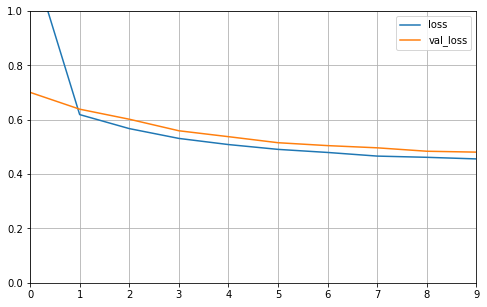

In [27]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
plot_learning_curves(history)

In [28]:
from scipy.stats import reciprocal
# f(x) = 1/(x*log(b/a)) a <= x <= b

param_distribution = {
    "hidden_layers":[1, 2, 3, 4],
    "layer_size": np.arange(1, 100),
    "learning_rate": reciprocal(1e-4, 1e-2),
}

from sklearn.model_selection import RandomizedSearchCV

random_search_cv = RandomizedSearchCV(sklearn_model,
                                      param_distribution,
                                      n_iter = 10,
                                      # cv = 3,
                                      n_jobs = 1)
random_search_cv.fit(x_train_scaled, y_train, epochs = 100,
                     validation_data = (x_valid_scaled, y_valid),
                     callbacks = callbacks)

# cross_validation: 训练集分成n份，n-1训练，最后一份验证.

d:\python\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 0s 33us/sample - loss: 2.7621 - val_loss: 1.8367
Epoch 2/100
7740/7740 [==============================] - 0s 23us/sample - loss: 1.3648 - val_loss: 1.1629
Epoch 3/100
7740/7740 [==============================] - 0s 23us/sample - loss: 0.9916 - val_loss: 0.9635
Epoch 4/100
7740/7740 [==============================] - 0s 23us/sample - loss: 0.8658 - val_loss: 0.8840
Epoch 5/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.8076 - val_loss: 0.8397
Epoch 6/100
7740/7740 [==============================] - 0s 23us/sample - loss: 0.7714 - val_loss: 0.8079
Epoch 7/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.7443 - val_loss: 0.7826
Epoch 8/100
7740/7740 [==============================] - 0s 24us/sample - loss: 0.7221 - val_loss: 0.7613
Epoch 9/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.7027 - val_loss: 0.742

KeyboardInterrupt: 

In [ ]:
print(random_search_cv.best_params_)
print(random_search_cv.best_score_)
print(random_search_cv.best_estimator_)

In [ ]:
model = random_search_cv.best_estimator_.model
model.evaluate(x_test_scaled, y_test)